## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [48]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [49]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [50]:
num_rows = df.shape[0]
num_rows

294478

c. The number of unique users in the dataset.

In [51]:
num_unique_users = df.groupby('user_id').count().shape[0]
num_unique_users

290584

d. The proportion of users converted.

In [52]:
num_users_converted = df.query('converted == 1').count()[0]/num_unique_users
num_users_converted

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [53]:
a = df.query('group == "treatment" and landing_page != "new_page"').count()[0]
b = df.query('group == "control" and landing_page == "new_page"').count()[0]
a + b

3893

f. Do any of the rows have missing values?

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [55]:
df_exp = df.query('group == "treatment" and landing_page == "new_page"')
df_cont = df.query('group == "control" and landing_page == "old_page"')
df2 = pd.concat([df_exp, df_cont])

In [56]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [57]:
df2.groupby('user_id').count().shape[0]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [58]:
test = df2['user_id'].duplicated()
test[test == True]

2893    True
Name: user_id, dtype: bool

c. What is the row information for the repeat **user_id**? 

In [59]:
df2.iloc[2893]

user_id                             723335
timestamp       2017-01-15 12:29:50.410123
group                            treatment
landing_page                      new_page
converted                                0
Name: 5917, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [60]:
df2 = df2.drop(2893)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [61]:
df2.query('converted >= 1').count()[0]/df2.count()[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [62]:
p_control = df2.query('converted >= 1 and group == "control"').count()[0]/df2.query('group == "control"').count()[0]
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [63]:
p_treatment = df2.query('converted >= 1 and group == "treatment"').count()[0]/df2.query('group == "control"').count()[0]
p_treatment

0.1188375070556328

d. What is the probability that an individual received the new page?

In [64]:
df2.query('landing_page == "new_page"').count()[0]/df2.count()[0]

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Your answer goes here.**

There is statistical evidence that the old page has a higher conversion rate but the difference is too small to prove any practical significance for changing to the new page.

<a id='ab_test'></a>
### Part II - A/B Test

### Null and alternative hypothesis


$H_0 = P_{old} >= P_{new}$

$H_1 = P_{old} < P_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [65]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [66]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [67]:
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [68]:
n_old = df2.query('landing_page == "old_page"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [69]:
 new_page_converted = np.random.binomial(n_new, p_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [70]:
 old_page_converted = np.random.binomial(n_old, p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [71]:
new_page_converted/n_new - old_page_converted/n_old

0.00082372741001254801

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [72]:
p_diffs = []

for _ in range(10000):
    new_conv = np.random.binomial(n_new, p_new)
    old_conv = np.random.binomial(n_old, p_old)
    diff = new_conv/n_new - old_conv/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  1.70000000e+01,   1.50000000e+02,   8.35000000e+02,
          2.20700000e+03,   3.15100000e+03,   2.38400000e+03,
          1.02100000e+03,   2.14000000e+02,   1.90000000e+01,
          2.00000000e+00]),
 array([-0.00448975, -0.00350481, -0.00251986, -0.00153492, -0.00054998,
         0.00043496,  0.0014199 ,  0.00240485,  0.00338979,  0.00437473,
         0.00535967]),
 <a list of 10 Patch objects>)

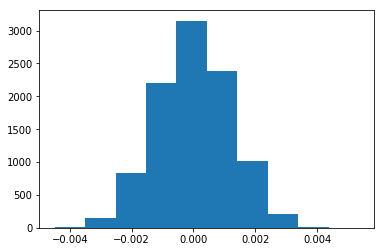

In [73]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [74]:
origional_diff = p_treatment - p_control

p_diffs = np.array(p_diffs)
null_vals = np.random.normal(p_old, p_diffs.std(), 10000)
(p_diffs > origional_diff).mean()

0.90169999999999995

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

The computation executed in section J calculates the probability of observing the current statistic derrived from the current sample given that the null hypothesis is true.

A P value of .893 indicates that there is no statistical evidence that we should reject the null hypothesis.  There is no evidence that the new page has higher conversion rates.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [75]:
import statsmodels.api as sm

convert_old = df.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df.query('landing_page == "old_page"').shape[0]
n_new = df.query('landing_page == "new_page"').shape[0]

In [76]:
convert_old, convert_new

(17739, 17498)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [77]:
from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

In [78]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3683341399998907, 0.9143962454534289)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
The z-score indicates that, since it does not exceed the critical value (1.959963984540054 at 95% confidence), we fail to reject the null hypothesis that the difference between the two proportions is zero.

The p-value computed indicates that there is a 91 percent chance that we will observe the same statistic given that the null is true therefore we should stick to the null being true.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**
Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [79]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [80]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [81]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 22 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        23:15:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

The P value for ab_page is 0.190. The P value in this calculation indicates the probability that the statistic for the average increase in conversion rate from the new page will be observed given that the null is true. The previous calcuation indicated the probability that the difference between the old page and new page is a non-zero value.  The z-test and the simulation both included one-tailed tests but not the regression.

It is a good idea to consider other factors into the regression model so that other correlations may be found between those factors and the desired result. If other correlations are found, said company can implement other strategies for achieving a certain goal.

A disadvantage of adding additional terms into the regression model is that there might be multicollinearity and cause the results to be inaccurrate.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [82]:
df3 = pd.read_csv('countries.csv')
new_df = df2.join(df3.set_index('user_id'), on='user_id')
new_df[['CA', 'UK', 'US']] = pd.get_dummies(new_df['country'])

In [83]:
lm2 = sm.OLS(new_df['converted'], new_df[['intercept', 'CA', 'UK']])
results2 = lm2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Sun, 22 Jul 2018   Prob (F-statistic):              0.201
Time:                        23:15:16   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1195      0.001    166.244      0.000       0.118       0.121
CA            -0.0042      0.003     -1.516      0.130      -0.010       0.001
UK             0.0010      0.001      0.746      0.455      -0.002       0.004
==============================================================================
Omnibus:                   125552.384   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414306.036
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         4.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [84]:
lm3 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'CA', 'UK']])
results3 = lm3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Jul 2018   Pseudo R-squ.:               2.323e-05
Time:                        23:15:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

<a id='conclusions'></a>

Through the examination of the variables of page and country both individually and simultaneously, it is concluded that there is no statistical evidence that either page or country has an effect on increasing conversion rate. All P values fail to fall below the .05% error acceptance rate.  The P value of a_b page is 0.19, the value relating to how reliable whether an old vs new page condition is in terms of predicting conversion rate.  The computation executed for the P value earlier indicated the probability of observing the current statistic derrived from the current sample given that the null hypothesis is true.

Based on the statistical findings, said company should not spend company resources on switching web pages.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])